In [1]:
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import numpy as np
import scipy
import matplotlib.gridspec as gridspec
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
from IPython.display import Image, display
from scipy.ndimage import gaussian_filter
%matplotlib inline

import cmocean

In [2]:
## CFSv2 IVT ##

def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=slice(10,50), longitude=slice(210,250))

filename_pattern =  '../data/CFSv2/netcdf_CFSv2_vertical_levels/201*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess)
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

da_SPFH = ds.spfh.sel(p=slice(1000,300))
da_V = ds.v.sel(p=slice(1000,300))
da_U = ds.u.sel(p=slice(1000,300))
pressure = ds.p.sel(p=slice(1000,300)).values

### Calculate IVT and IWV
g = -9.81 # gravity constant
pressure = pressure*100 # convert from hPa to Pa
ivt_u = scipy.integrate.trapz(da_U*da_SPFH, pressure, axis=1)/g
print(ivt_u.shape)
ivt_v = scipy.integrate.trapz(da_V*da_SPFH, pressure, axis=1)/g
print(ivt_v.shape)
ivt_total = np.sqrt(ivt_u**2 + ivt_v**2)

iwv = scipy.integrate.trapz(da_SPFH, pressure, axis=1)/g

ds size in GB 0.17

(12, 81, 81)
(12, 81, 81)


In [3]:
## average IVT to daily - leaving 3 days of IVT ##
## load into ds then resample to daily

ivt_ds = xr.Dataset({'ivtv': (['time', 'lat', 'lon'], ivt_v),
                     'ivtu': (['time', 'lat', 'lon'], ivt_u),
                     'ivt': (['time', 'lat', 'lon'], ivt_total)},
                coords={'time': (['time'], ds.time),
                        'lat': (['lat'], ds.latitude),
                        'lon': (['lon'], ds.longitude)})
ivt_daily = ivt_ds.resample(time='1D').mean()
ivt_daily

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 81, time: 3)
Coordinates:
  * time     (time) datetime64[ns] 2019-03-04 2019-03-05 2019-03-06
  * lat      (lat) float64 10.0 10.5 11.0 11.5 12.0 ... 48.0 48.5 49.0 49.5 50.0
  * lon      (lon) float64 210.0 210.5 211.0 211.5 ... 248.5 249.0 249.5 250.0
Data variables:
    ivtv     (time, lat, lon) float32 -40.07535 -35.014107 ... -5.8716683
    ivtu     (time, lat, lon) float32 -364.07394 -358.4411 ... 11.240658
    ivt      (time, lat, lon) float32 366.41235 360.54095 ... 17.618595

In [4]:
## Hail Data ##
filename = '../data/NOAA_SWDI/swdiws_nx3hail_all_20190306_bbox_-131_31_-116_41.csv'
hail_df = pd.read_csv(filename, header=0, parse_dates=['ZTIME'], skipfooter=3,
                     engine='python')
## Make a column that shows just the day of hail
hail_df['day'] = hail_df.ZTIME.dt.day
hail_df['freq'] = 1.0
# hail_df

In [5]:
df_hail_tidx = hail_df.set_index('ZTIME')
df_hail_tidx = df_hail_tidx.sort_index()
df_hail_sum = df_hail_tidx.resample('15min').sum()
# df_avg = df_hail_tidx.resample('15min').mean()
# df_hail_sum

In [6]:
### Lightning Data
filename = '../data/ENTLN/ENTLN_flashes_-_UC_Santa_Barbara_030419_00UTC_to_030819_00UTC_flash_combined.csv'
df = pd.read_csv(filename, header=0, parse_dates=['timestamp'])
df['day'] = df.timestamp.dt.day ## Make a column that shows just the day of the lightning strike
#greater than the start date and smaller than the end date
mask = (df['timestamp'] <= '2019-03-07-00')
df = df.loc[mask]
df['freq'] = df.icmultiplicity + df.cgmultiplicity

In [7]:
df_time_index = df.set_index('timestamp')
df_time_index = df_time_index.sort_index()
df_sum = df_time_index.resample('15min').sum()
df_avg = df_time_index.resample('15min').mean()

In [8]:
## Colormap information
lightning_cmap = cmocean.cm.dense
lightning_clevs = [1, 5, 10, 20, 40, 60, 80, 100, 150, 200, 300, 400]
lightning_norm = mcolors.BoundaryNorm(lightning_clevs, lightning_cmap.N)

In [9]:
def interp_lightning(df, latitude_bins, longitude_bins):
    ''' Interpolate lightning point data to frequency per grid cell 
    based on latitude and longitude bins'''
    latitude_group= pd.cut(df['latitude'], bins=latitude_bins)
    longitude_group= pd.cut(df['longitude'], bins=longitude_bins)
    new_df = df.groupby([(latitude_group), (longitude_group)]).sum()
    lightning_count = new_df['freq'].values
    lightning_count = lightning_count.reshape((latitude_bins.size-1, longitude_bins.size-1))
    
    return lightning_count
    

In [10]:
# Interpolate each day's worth of lightning so that the frequency is flashes per day

mask_4March = (df['timestamp'] >= '2019-03-04-00') & (df['timestamp'] < '2019-03-05-00')
df4 = df.loc[mask_4March]

mask_5March = (df['timestamp'] >= '2019-03-05-00') & (df['timestamp'] < '2019-03-06-00')
df5 = df.loc[mask_5March]

mask_6March = (df['timestamp'] >= '2019-03-06-00') & (df['timestamp'] < '2019-03-07-00')
df6 = df.loc[mask_6March]

latitude_bins = np.arange(20.0, 50.1, 0.1)
longitude_bins = np.arange(-140.0, -109.9, 0.1)

lightning_count4 = interp_lightning(df4, latitude_bins, longitude_bins)
lightning_count5 = interp_lightning(df5, latitude_bins, longitude_bins)
lightning_count6 = interp_lightning(df6, latitude_bins, longitude_bins)

./figures/fS7.png


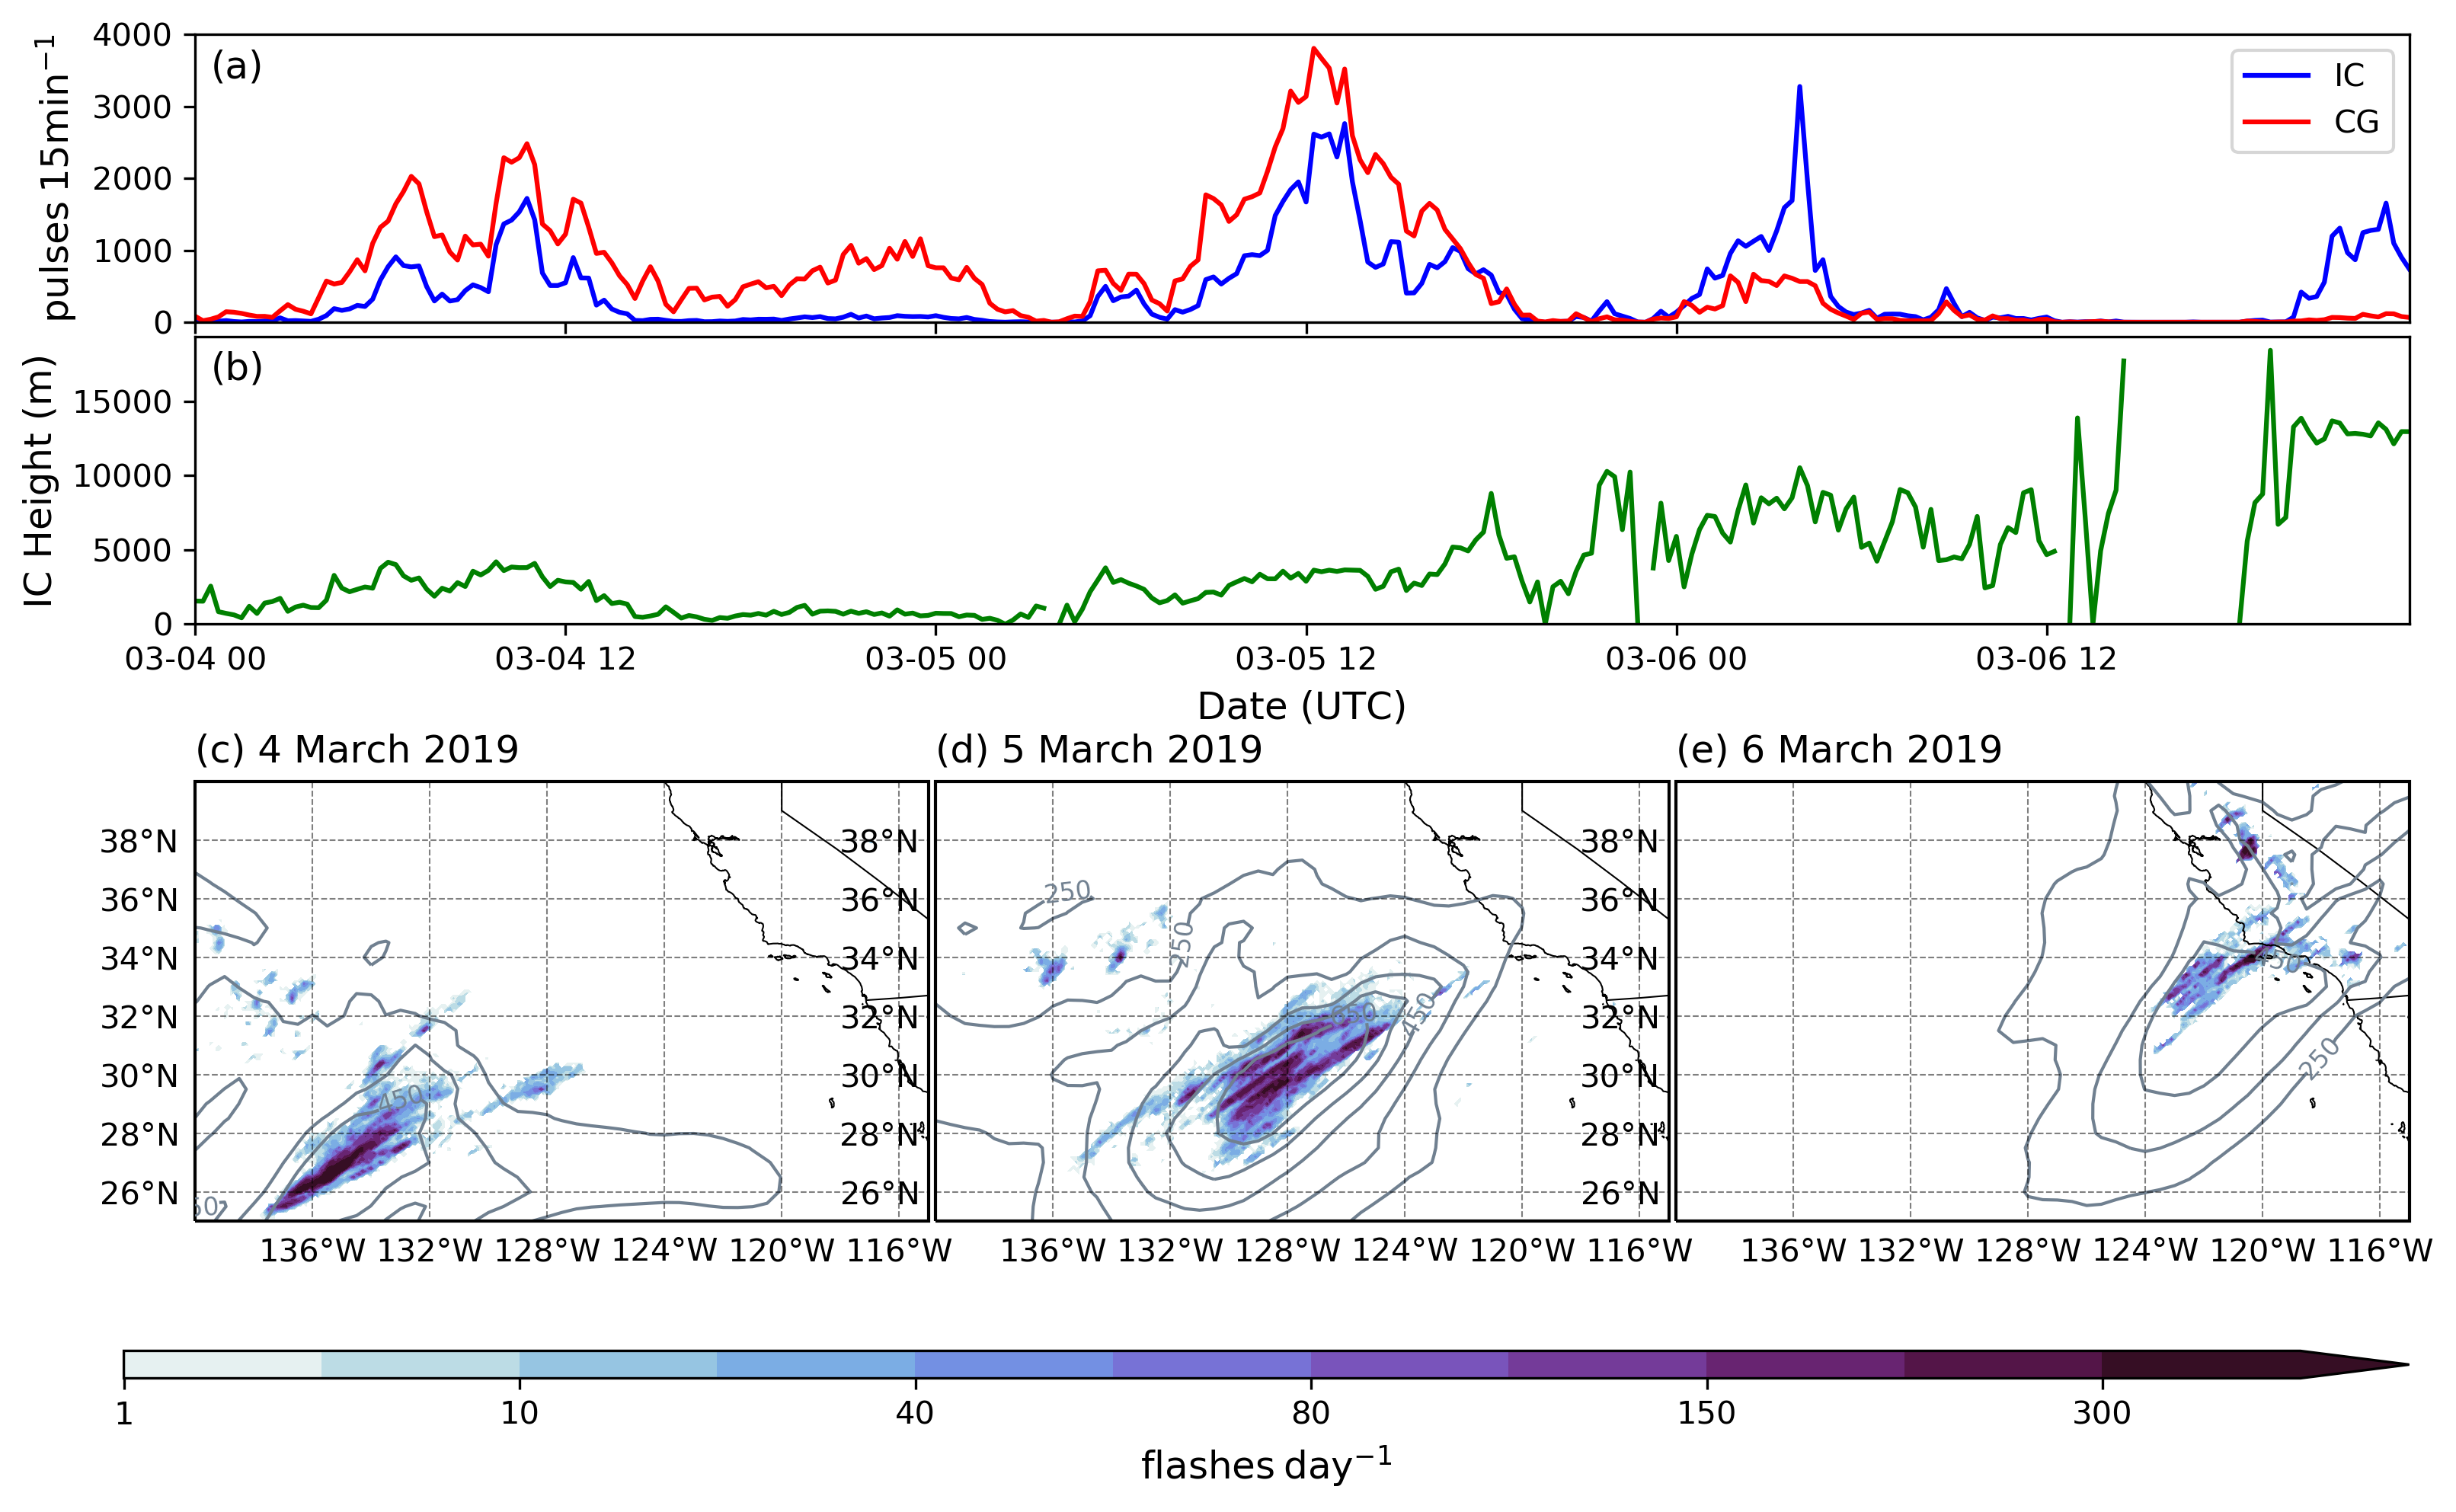

<Figure size 3750x1800 with 0 Axes>

In [11]:
## All plots together
## figsize=(width,height (inches))
fig = plt.figure(figsize=(12.5,6.))
fig.dpi = 300
fname = './figures/fS7'
fmt1 = 'png'
fmt2 = 'pdf'

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = gridspec.GridSpec(nrows=2, ncols=3)
gs.update(top=0.98, bottom=0.55, hspace=0.05)
gs2 = gridspec.GridSpec(nrows=1, ncols=3)
gs2.update(top=0.53, bottom=0.02, hspace=0.01, wspace=0.01)
gs3 = gridspec.GridSpec(nrows=1, ncols=3)
gs3.update(top=0.02, bottom=0.00, left=0.1, right=0.9)

## [rows index, columns index]

######################################################
# Plot for Figure S7a - #IC and CG lightning strikes #
######################################################

ax1 = plt.subplot(gs[0, :])

ax1.plot_date(df_sum.index, df_sum.icmultiplicity, label='IC', color='b',
             linestyle='-', marker=None)
ax1.plot_date(df_sum.index, df_sum.cgmultiplicity, label='CG', color='r',
             linestyle='-', marker=None)

ax1.set_ylim(0,4000.)
ax1.set_xlim(df_sum.index[0], df_sum.index[-1])
ax1.legend()
plt.ylabel('$\mathrm{pulses \: 15min^{-1}}$', fontsize=12.)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_ticklabels([])

plt.annotate('(a)', (5, 77), xycoords='axes points', fontsize=12.)

####################################
# Plot for Figure S7b - #IC Height #
####################################

ax2 = plt.subplot(gs[1, :])
ax2.plot_date(df_avg.index, df_avg.icheight, color='g',
             linestyle='-', marker=None)
plt.xlabel('Date (UTC)', fontsize=12.)
ax2.set_xlim(df_avg.index[0], df_avg.index[-1])
ax2.set_ylim(bottom=0.0)
plt.ylabel('IC Height (m)', fontsize=12.)

plt.annotate('(b)', (5, 77), xycoords='axes points', fontsize=12.)

##################################################
# Plot for Figure S7c - #All Lightning Locations #
##################################################
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

datacrs = ccrs.PlateCarree()
mapcrs = ccrs.PlateCarree()
ext = [-115.0, -140.0, 25.0, 40.0]

kw_clabels = {'fontsize': 8, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
             'rightside_up': True, 'use_clabeltext': True}
ivtclevs = np.arange(250,1150,100)

results = [lightning_count4, lightning_count5, lightning_count6]
subtitles = ['(c) 4 March 2019', '(d) 5 March 2019', '(e) 6 March 2019']
### Day 1-3 ###
for i in np.arange(len(results)):
    ax3 = plt.subplot(gs2[:, i], projection=datacrs)
    ax3.set_extent(ext, crs=datacrs)

    cf = ax3.contourf(longitude_bins[:-1], latitude_bins[:-1], results[i], 
                      transform=mapcrs, extend='max',
                      cmap=lightning_cmap, 
                      norm=lightning_norm, levels=lightning_clevs)

    ## Plot IVT - contours ##
    lons = ivt_daily.lon
    lats = ivt_daily.lat
    ivt_sm = gaussian_filter(ivt_daily.ivt[i], sigma=0.01)
    cs = ax3.contour(lons, lats, ivt_sm, ivtclevs, colors='slategray', linewidths=1.0,
                      linestyles='solid', transform=datacrs)
    plt.clabel(cs, cs.levels[::2], **kw_clabels)
    
    gl = ax3.gridlines(crs=mapcrs, draw_labels=True,
                      linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-140., -110., 4))
    gl.ylocator = mticker.FixedLocator(np.arange(24, 44, 2))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax3.coastlines(linewidths=0.5, resolution='10m')
    ax3.add_feature(states_provinces, edgecolor='k', linewidths=0.5)
    ax3.add_feature(cfeature.BORDERS, linewidths=0.5)
    ax3.set_title(subtitles[i], loc='left')

# Add color bar
cax1 = plt.subplot(gs3[:, :])
cbar = plt.colorbar(cf, cax=cax1, orientation='horizontal', shrink=0.45)
cbar.ax.set_xlabel('$\mathrm{flashes \: day^{-1}}$', fontsize=12)

# Show the plot
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

./figures/fS7_cde.png


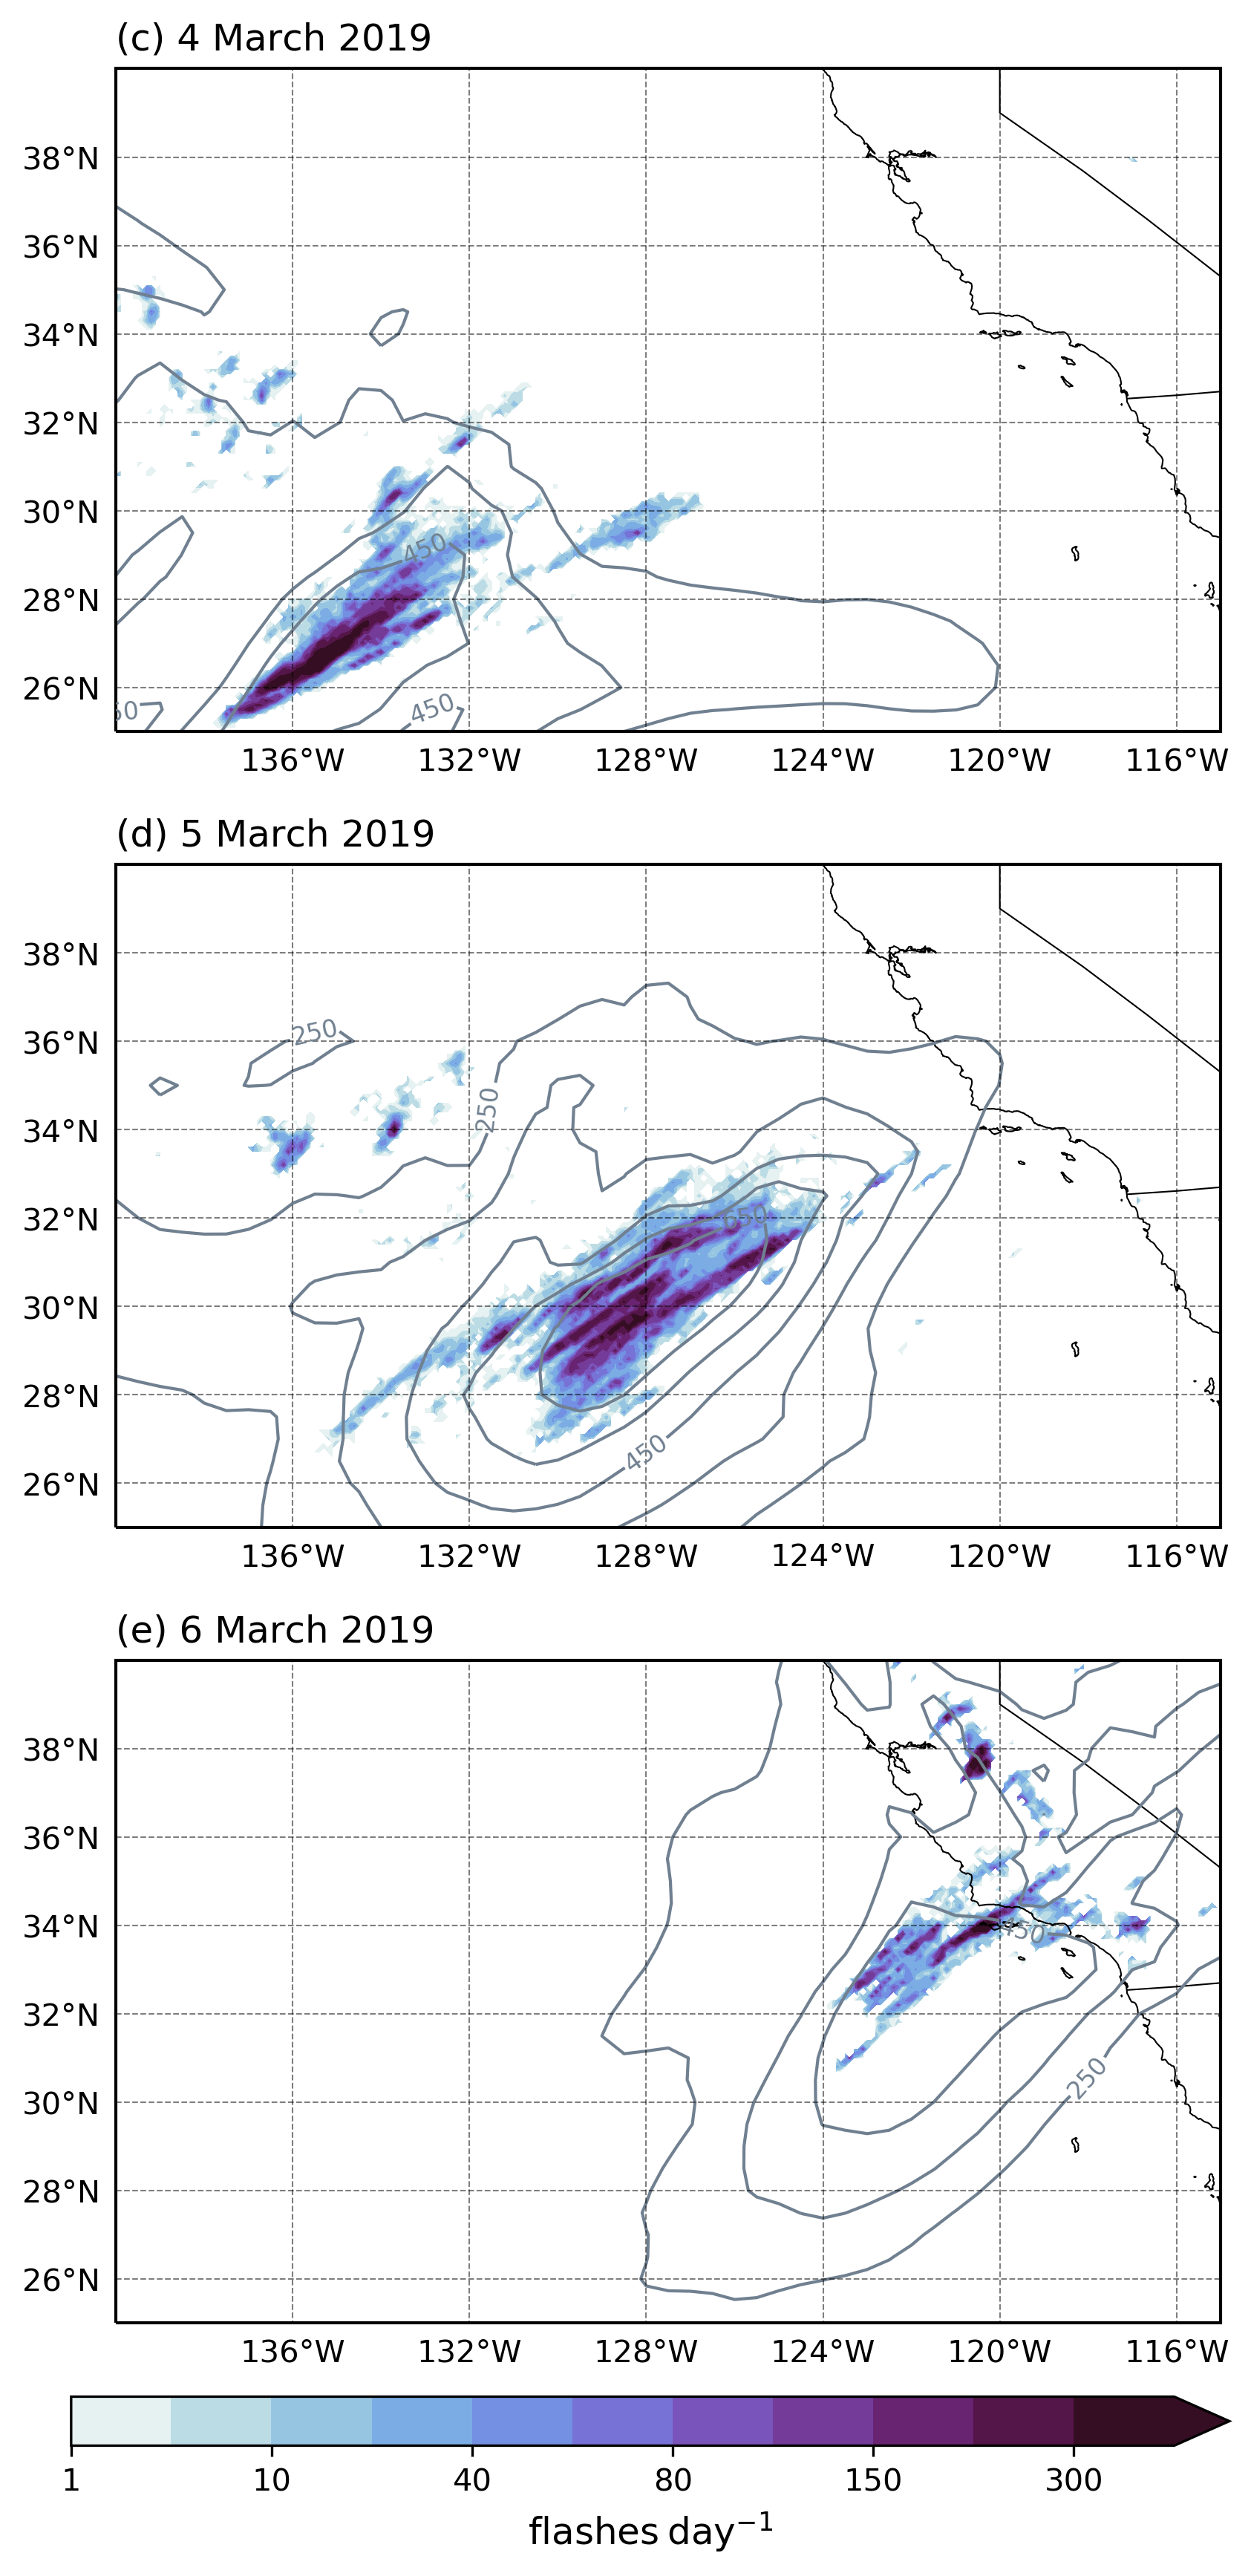

<Figure size 1950x3300 with 0 Axes>

In [16]:
## All plots together
## figsize=(width,height (inches))
fig = plt.figure(figsize=(6.5,11.))
fig.dpi = 300
fname = './figures/fS7_cde'
fmt1 = 'png'
fmt2 = 'pdf'

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs2 = gridspec.GridSpec(nrows=3, ncols=1)
gs2.update(top=0.97, bottom=0.05, hspace=0.2, wspace=0.01)
gs3 = gridspec.GridSpec(nrows=3, ncols=1)
gs3.update(top=0.02, bottom=0.00, left=0.1, right=0.9)

## [rows index, columns index]

##################################################
# Plot for Figure S7c - #All Lightning Locations #
##################################################
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

datacrs = ccrs.PlateCarree()
mapcrs = ccrs.PlateCarree()
ext = [-115.0, -140.0, 25.0, 40.0]

kw_clabels = {'fontsize': 8, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
             'rightside_up': True, 'use_clabeltext': True}
ivtclevs = np.arange(250,1150,100)

results = [lightning_count4, lightning_count5, lightning_count6]
subtitles = ['(c) 4 March 2019', '(d) 5 March 2019', '(e) 6 March 2019']
### Day 1-3 ###
for i in np.arange(len(results)):
    ax3 = plt.subplot(gs2[i, :], projection=datacrs)
    ax3.set_extent(ext, crs=datacrs)

    cf = ax3.contourf(longitude_bins[:-1], latitude_bins[:-1], results[i], 
                      transform=mapcrs, extend='max',
                      cmap=lightning_cmap, 
                      norm=lightning_norm, levels=lightning_clevs)

    ## Plot IVT - contours ##
    lons = ivt_daily.lon
    lats = ivt_daily.lat
    ivt_sm = gaussian_filter(ivt_daily.ivt[i], sigma=0.01)
    cs = ax3.contour(lons, lats, ivt_sm, ivtclevs, colors='slategray', linewidths=1.0,
                      linestyles='solid', transform=datacrs)
    plt.clabel(cs, cs.levels[::2], **kw_clabels)
    
    gl = ax3.gridlines(crs=mapcrs, draw_labels=True,
                      linewidth=.5, color='black', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-140., -110., 4))
    gl.ylocator = mticker.FixedLocator(np.arange(24, 44, 2))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax3.coastlines(linewidths=0.5, resolution='10m')
    ax3.add_feature(states_provinces, edgecolor='k', linewidths=0.5)
    ax3.add_feature(cfeature.BORDERS, linewidths=0.5)
    ax3.set_title(subtitles[i], loc='left')

# Add color bar
cax1 = plt.subplot(gs3[:, :])
cbar = plt.colorbar(cf, cax=cax1, orientation='horizontal', shrink=0.45)
cbar.ax.set_xlabel('$\mathrm{flashes \: day^{-1}}$', fontsize=12)

# Show the plot
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))